# 根據keyword推薦活動

輸入以下對話  

有沒有跟matlab有關的活動  
設定 matlab 為 @sys.any  

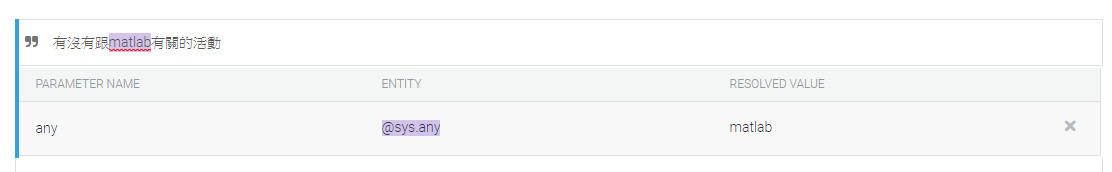

https://notebooks.azure.com/fcu-liu/libraries/socialbot/html/02-basic-ChatBot/keyword.png

In [3]:
#活動keyword
import requests
from bs4 import BeautifulSoup,Tag
import pandas as pd
from datetime import datetime
from dateutil import parser

def get_keyword_activity(keyword=None):
    html = requests.get("http://news.fcu.edu.tw/wSite/lp?ctNode=15361&mp=9000&pagesize=50")
    soup = BeautifulSoup(html.content,"lxml")

    table = soup.find('table',{'class':'tb'})

    row_titles = []
    post_dates = []
    titles = []
    links = []
    start_dates = []
    end_dates = []
   
    for title in table.find('tr').find_all('th'):
        row_titles.append(title.text.strip())

    row_titles.append('連結')

    msg = ''
    for row in table.find_all('tr')[1:]:
        fields = row.find_all('td')
        post_date = fields[0].text.strip()
        title = fields[1].text.strip()
        link = 'http://news.fcu.edu.tw/wSite/'+fields[1].find('a', href=True).get('href')
        start_date = fields[2].text.strip()
        end_date = fields[3].text.strip()
        post_dates.append(post_date)
        titles.append(title)
        links.append(link)
        start_dates.append(start_date)
        end_dates.append(end_date)

    activity_df = pd.DataFrame({"張貼日":post_dates,"標題":titles,"開始時間":start_dates,"截止時間":end_dates,"連結":links},columns = row_titles)
    activity_df['張貼日'] =  pd.to_datetime(activity_df['張貼日'], format='%Y-%m-%d')
    activity_df['開始時間'] =  pd.to_datetime(activity_df['開始時間'], format='%Y-%m-%d')
    activity_df['截止時間'] =  pd.to_datetime(activity_df['截止時間'], format='%Y-%m-%d')

    activity_df = activity_df.sort_values(by='開始時間')

    if keyword!=None:
        activity_df = activity_df[activity_df['標題'].str.lower().str.contains(keyword.lower())]
    
    msg = ''
    for index,activity in activity_df.iterrows():
        msg += activity['開始時間'].strftime("%Y-%m-%d") +' ' + activity['標題']+'\n'+activity['連結']+'\n'
    msg.strip()
    if msg=='':
        msg = '沒有活動'
    
    return msg

In [2]:
import json
from flask import Flask, request, make_response, jsonify

app = Flask(__name__)


@app.route("/")
def verify():
    return "Hello world", 200


@app.route('/', methods=['POST'])
def webhook():
    req = request.get_json(silent=True, force=True)
    print(req)
    keyword=None
    if req['queryResult']['parameters']['any'] != '':
        keyword = req['queryResult']['parameters']['any']
    res = {"fulfillmentText": get_keyword_activity(keyword)}
    return make_response(jsonify(res))

if __name__ == '__main__':
    app.run(port=5000)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
